<a href="https://colab.research.google.com/github/MortezaMahdaviMortazavi/DeepLearning-Introduction/blob/master/RNN/CharacterLevelRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import string
import matplotlib.pyplot as plt

In [3]:
file = open('dinos.txt','r').read()
names = file.split('\n')
string.printable

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [4]:
def character_tokenizer():
  all_characters = string.printable
  char2int = {}
  int2char = {}
  index = 0
  for ch in all_characters:
    char2int[ch] = index
    int2char[index] = ch
    index+=1
    
  return char2int , int2char


In [5]:
class RNNGenerator(nn.Module):
  def __init__(self,input_dim,hidden_dim,output_dim,num_layers):
    super(RNNGenerator,self).__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    # input_dim = length of embedding vector
    # hidden_dim = number of nodes in each layer of rnn
    # output_dim = number of output characters
    self.dropout = nn.Dropout(0.2)
    self.bn = nn.BatchNorm1d(output_dim)
    self.embedding = nn.Embedding(input_dim,hidden_dim)
    self.rnn = nn.GRU(input_size=hidden_dim,hidden_size=hidden_dim,num_layers=num_layers)
    self.fc = nn.Linear(hidden_dim,output_dim)

  def forward(self,X,hidden):
    embed_out = self.embedding(X) # Shape : None
    embed_out = self.dropout(embed_out) # Shape : None

    rnn_out , hidden = self.rnn(embed_out.unsqueeze(1),hidden) # Shape : None
    rnn_out = self.dropout(rnn_out.reshape(rnn_out.shape[0],-1))
    decode_out = self.fc(rnn_out)
    # decode_out = self.bn(decode_out)
    return decode_out , hidden

  def init_hidden(self,batch_size,D=False): # D is true if our rnn is a bidirectional rnn
    coeff_ = 2 if D is True else 1
    hidden = Variable(torch.zeros(coeff_*self.num_layers,batch_size,self.hidden_dim))
    return hidden

In [6]:
class ConvolutionGenerator(nn.Module):
  def __init__(self):
    pass

  def forward(self):
    pass

In [15]:
class Generator:
  def __init__(self):
    self.chunk_len = 250
    self.n_epochs = 3000
    self.batch_size = 1
    self.print_every_epoch = 100
    self.lr = 0.002
    self.num_layers = 3
    self.hidden_dim = 256
    self.input_dim = 100
    self.output_dim = 100
    self.train_loss = np.zeros(3100)

  def char2tensor(self,string):
    char2int = character_tokenizer()[0]
    tensor = torch.zeros(len(string)).long()
    for ch in range(len(string)):
      tensor[ch] = char2int[string[ch]]
    
    return tensor

  def setSettings(self):
    self.model = RNNGenerator(self.input_dim,self.hidden_dim,self.output_dim,self.num_layers)
    self.optimizer = torch.optim.Adam(filter(
        lambda p:p.requires_grad,self.model.parameters()
      ),lr=self.lr
    )
    self.criterion = nn.CrossEntropyLoss()
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  def get_random_batch(self):
    char2int = character_tokenizer()[0]
    start_idx = np.random.randint(0,len(file)-self.chunk_len)
    end_idx = start_idx + self.chunk_len + 1
    chunk = file[start_idx:end_idx]
    inp_tensor = torch.zeros(self.batch_size,self.chunk_len)
    target_tensor = torch.zeros(self.batch_size,self.chunk_len)

    for idx in range(self.batch_size):
      inp_tensor[idx,:] = self.char2tensor(chunk[:-1])
      target_tensor[idx,:] = self.char2tensor(chunk[1:])

    inp_tensor = inp_tensor.long()
    target_tensor = target_tensor.long()
    return inp_tensor,target_tensor

  def generate(self, initial_str="A", predict_len=20, temperature=0.85):
    int2char = character_tokenizer()[1]
    hidden = self.model.init_hidden(batch_size=self.batch_size).to(self.device)
    initial_input = self.char2tensor(initial_str).to(self.device)
    predicted = initial_str

    for p in range(len(initial_str) - 1):
        _, hidden = self.model(
            initial_input[p].view(1).to(self.device), hidden.to(self.device)
        )

    last_char = initial_input[-1]

    for p in range(predict_len):
        output, hidden = self.model(
            last_char.view(1).to(self.device), hidden.to(self.device)
        )
        output_dist = output.data.view(-1).div(temperature).exp()
        top_char = torch.multinomial(output_dist, 1)[0]
        predicted_char = int2char[int(top_char.cpu())]
        predicted += predicted_char
        last_char = self.char2tensor(predicted_char)

    return predicted 


  def train(self):
    self.setSettings()
    self.model = self.model.to(self.device)
    self.model.train()

    print("################## Start training #################")
    for epoch in range(1,self.n_epochs+1):
      _input , target = self.get_random_batch()
      _input = _input.to(self.device)
      target = target.to(self.device)
      hidden = self.model.init_hidden(batch_size=self.batch_size).to(self.device)
      loss = 0

      self.model.zero_grad()
      for c in range(self.chunk_len):
        output , hidden = self.model(_input[:,c],hidden)
        loss+=self.criterion(output,target[:,c])

      loss.backward()
      self.optimizer.step()
      loss = loss.item()/self.chunk_len
      self.train_loss[epoch] = loss

      if epoch % self.print_every_epoch==0:
        print(f"In epoch {epoch} loss is : {loss}")
        print(self.generate())

    return self.train_loss


In [16]:
generator = Generator()
train_loss = generator.train()

################## Start training #################
In epoch 100 loss is : 2.054987548828125
Artosaurus
Oronhomier
In epoch 200 loss is : 1.7343463134765624
Arator
Fapenngosaurus
In epoch 300 loss is : 1.8339779052734375
Avelodon
Nulatonyasia
In epoch 400 loss is : 1.80342578125
Artosaurus
Karchasaur
In epoch 500 loss is : 1.9094437255859376
Andalasaurus
Sucomapr
In epoch 600 loss is : 1.4764483642578126
Asaurus
Chiondocephal
In epoch 700 loss is : 1.340015625
Anghiongia
Aklodon
Al
In epoch 800 loss is : 0.952197021484375
Auma
Asiasaurus
Acher
In epoch 900 loss is : 1.0219826049804688
Avatrodon
Crichilopho
In epoch 1000 loss is : 0.6531767578125
Antanisaurus
Pachysuc
In epoch 1100 loss is : 0.547292724609375
Anglong
Axalaeosaurus
In epoch 1200 loss is : 1.448139892578125
Arnathysis
Ephoenosau
In epoch 1300 loss is : 0.5496004028320313
Agnathus
Austaia
Athc
In epoch 1400 loss is : 0.42833642578125
Amargosaurus
Ategocer
In epoch 1500 loss is : 0.426267822265625
Argosaurus
Asiacerato
In e

In [18]:
generator.generate().split('\n')

['Anschia', 'Therioceratop']

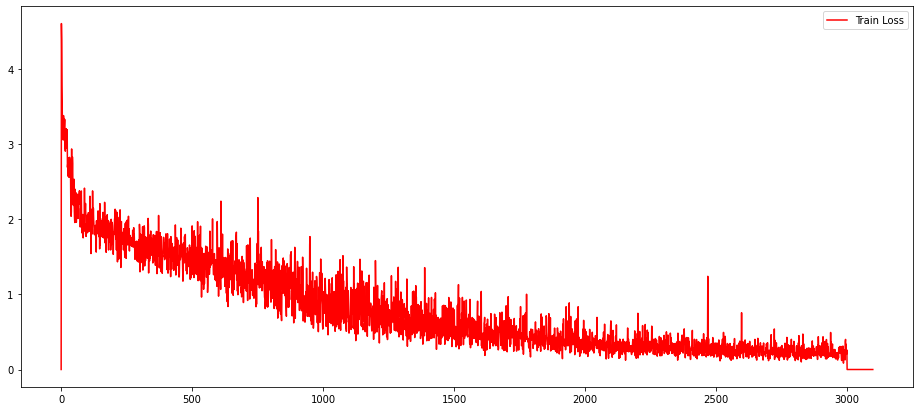

In [30]:
plt.figure(figsize=(16,7))
plt.plot(train_loss,c='red',label='Train Loss')
plt.legend()
plt.show()